In [1]:
import gc
gc.collect()

197

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("kidsInMindSubtitles2004.csv")
df.shape

(2004, 15)

In [4]:
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [5]:
model_name = "facebook/bart-large-cnn"  
class BartForRegression(torch.nn.Module):
    def __init__(self):
        super(BartForRegression, self).__init__()
        self.bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
        self.dropout = torch.nn.Dropout(0.1)
        self.regression_head = torch.nn.Linear(self.bart_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bart_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        hidden_state = outputs.decoder_hidden_states[-1]
        regression_output = self.regression_head(self.dropout(hidden_state[:, 0]))

        return regression_output.squeeze(-1)

In [6]:
class SubtitlesDataset(Dataset):
    def __init__(self, texts, labels_regression, tokenizer, max_length):
        self.texts = texts
        self.labels_regression = labels_regression
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label_regression = float(self.labels_regression[idx])

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return input_ids, attention_mask, label_regression

In [7]:
texts = df['subtitles'].tolist()
labels_regression = df['Language'].tolist()

In [8]:
train_texts, val_texts, train_labels_regression, val_labels_regression = train_test_split(texts, 
                                                                                          labels_regression, 
                                                                                          test_size=0.1, 
                                                                                          random_state=42)

In [9]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForRegression()

In [10]:
#!pip install numpy==1.20

In [11]:
train_dataset = SubtitlesDataset(train_texts, train_labels_regression, tokenizer, max_length=128)
val_dataset = SubtitlesDataset(val_texts, val_labels_regression, tokenizer, max_length=128)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [13]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=2.2908675418875646e-06)
num_epochs = 25
train_losses = []
val_losses = []

In [14]:
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

/tmp/ipykernel_548266/1399904515.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [ ]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels_regression = batch
        optimizer.zero_grad()

        regression_output = model(input_ids=input_ids, attention_mask=attention_mask)
        labels_regression = labels_regression.float()
        regression_output = regression_output.squeeze(-1)
        loss = torch.nn.functional.mse_loss(regression_output, labels_regression)
        #print(loss)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels_regression = batch
            regression_output = model(input_ids=input_ids, attention_mask=attention_mask)
            regression_output = regression_output.squeeze(-1)
            val_loss = torch.nn.functional.mse_loss(regression_output, labels_regression)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 1/25, Training Loss: 10.5638


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 2/25, Training Loss: 7.3209


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 3/25, Training Loss: 7.1929


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 4/25, Training Loss: 6.9324


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 5/25, Training Loss: 6.6065


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 6/25, Training Loss: 5.8859


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 7/25, Training Loss: 5.2917


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 8/25, Training Loss: 4.6850


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 9/25, Training Loss: 4.0310


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 10/25, Training Loss: 3.4420


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 11/25, Training Loss: 3.0652


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 12/25, Training Loss: 2.7860


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 13/25, Training Loss: 2.4019


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 14/25, Training Loss: 2.1851


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 15/25, Training Loss: 1.8885


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 16/25, Training Loss: 1.7062


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 17/25, Training Loss: 1.5781


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 18/25, Training Loss: 1.4142


  0%|          | 0/57 [00:00<?, ?it/s]

In [ ]:
data = {'Epoch': range(1, num_epochs + 1),
        'Train Loss': train_losses,
        'Validation Loss': val_losses}

In [ ]:
len(val_losses)

In [18]:
df2 = pd.DataFrame(data)
excel_filename = "losses_per_epoch2.xlsx"
df2.to_excel(excel_filename, index=False)
print("Train and Validation Losses per Epoch saved to:", excel_filename)

Train and Validation Losses per Epoch saved to: losses_per_epoch2.xlsx


In [37]:
#torch.save(model.state_dict(), 'models/BartForRegression.pth')

In [35]:
model = BartForRegression()

In [36]:
model.load_state_dict(torch.load('models/BartForRegression.pth'))

<All keys matched successfully>

In [13]:
test_text = df['subtitles'][1700]

In [14]:
inputs = tokenizer(test_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

# Get input_ids and attention_mask from the tokenizer output
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

In [15]:
model.eval()

with torch.no_grad():
    regression_output = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)

predicted_score = regression_output.item()

In [16]:
print("Predicted Regression Score:", predicted_score)

Predicted Regression Score: 0.18485945463180542


In [17]:
df['Language'][1700]

5

In [18]:
df_excel=pd.read_excel("./losses_per_epoch2.xlsx")

In [19]:
len(df_excel)

25

In [20]:
#df_excel.columns

In [21]:
import matplotlib.pyplot as plt

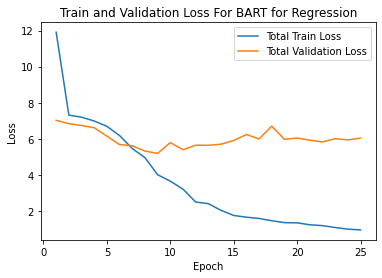

In [22]:
plt.plot(range(1, 26), df_excel['Train Loss'].tolist(), label='Total Train Loss')
plt.plot(range(1, 26), df_excel['Validation Loss'].tolist(), label='Total Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss For BART for Regression')
plt.legend()
plt.show()

In [28]:
df = df[1800:1805].reset_index(drop = True)

In [29]:
df.shape

(5, 15)

In [30]:
predictions=[]

In [31]:
for sub in df.subtitles:
    inputs = tokenizer(sub, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    with torch.no_grad():
        regression_output = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
        predicted_score = regression_output.item()
    predictions.append(predicted_score)
    

In [32]:
df_predictions=pd.DataFrame({ 'Language_Score':df['Language'].tolist(),"Predcited_Score":predictions})

In [33]:
df_predictions.head()

,Language_Score,Predcited_Score
0,1,0.338820
1,5,-0.099284
2,2,0.291905
3,6,0.015218
4,7,-0.053623


In [34]:
df_predictions[1803:]

,Language_Score,Predcited_Score


In [38]:
import numpy as np

In [39]:
#df_predictions=pd.read_excel('./predictions_BartForRegression.xlsx')

In [40]:
df_predictions

,Language_Score,Predcited_Score
0,5,3.753606
1,10,10.582192
2,5,5.527488
3,5,5.070580
4,9,8.121773
...,...,...
1999,1,1.109995
2000,1,2.468549
2001,6,7.052896
2002,6,6.756784


In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

true_labels = np.array(df_predictions['Language_Score'].tolist())
predicted_scores=np.array(df_predictions['Predcited_Score'].tolist())
mse = mean_squared_error(true_labels[1803:], predicted_scores[1803:])
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_labels, predicted_scores)
r2 = r2_score(true_labels, predicted_scores)
evs = explained_variance_score(true_labels, predicted_scores)

In [42]:
print("mse: ",mse)
print("rmse: ",rmse)
print("mae: ",mae)
print("r2: ",r2)
print("evs: ",evs)

mse:  2.1610417387986565
rmse:  1.4700482096851981
mae:  0.8017503249490571
r2:  0.8126009004293708
evs:  0.8221079699195839


In [43]:
#df['Language_Description'][1803:]

In [44]:

predicted_list = []
ground_truth_list = []
subtitle_list = []
summary_list = []


for text, rating, lang_sum in zip(df.subtitles[1803:], df['Language'][1803:], df['Language_Description'][1803:]):
    
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    with torch.no_grad():
        regression_output = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
        predicted_score = regression_output.item()
    
    predicted_list.append(predicted_score)
    ground_truth_list.append(rating)
    subtitle_list.append(text)
    summary_list.append(lang_sum)
    

In [45]:
df_predictions = pd.DataFrame({ 'Language_Score':ground_truth_list,"Predcited_Score":predicted_list, 
                            "subtitle":subtitle_list, "language_summary":summary_list})

In [46]:
#df_predictions['']

In [47]:
foul_words = [x.lower().strip() for x in open("../Kritika_project/final_lexicon_aaai.txt").readlines()]

In [48]:
len(foul_words)

1311

In [49]:
from gensim.parsing.preprocessing import remove_stopwords
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
tqdm.pandas()

In [50]:

def clean_text(text):
    
    new_filtered_text = remove_stopwords(text)
    
    return new_filtered_text.lower()


In [52]:
def get_inappropriate_words(text):
    
    
    text_list = text.split()
    inappropriate_words = [word for word in text_list if word in foul_words]
    
    
    return inappropriate_words

In [53]:
df_predictions['cleaned_text'] = df_predictions['subtitle'].progress_apply(clean_text)

  0%|          | 0/201 [00:00<?, ?it/s]

In [54]:
df_predictions['inappropriate_words'] = df_predictions['cleaned_text'].progress_apply(get_inappropriate_words)

  0%|          | 0/201 [00:00<?, ?it/s]

In [57]:
df_predictions['inappropriate_words_count'] = [len(x) for x in df_predictions['inappropriate_words']]

In [13]:
df_predictions.to_csv("test_dataset__bart_model_language_rating_prediction.csv", index = False)